# General configuration

## Libraries

In [1]:
# First we need to import the os library to change the env parameter for illia
import os
import sys
from abc import abstractmethod
from typing import Tuple, Any

import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

2024-12-03 12:17:34.325146: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 12:17:34.613202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 12:17:34.613264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 12:17:34.655835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 12:17:34.748094: I tensorflow/core/platform/cpu_feature_guar

## Random seeds

Set random seeds for reproducibility

In [2]:
np.random.seed(0)
torch.manual_seed(0)
tf.random.set_seed(0)

## Take care of paths

In [3]:
print(f"Current working directory :{os.getcwd()}")
print(f"Current sys path :{sys.path}")

Current working directory :/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia/examples
Current sys path :['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dani/dani/lib/python3.10/site-packages', '/home/dani/dani/lib/python3.10/site-packages/setuptools/_vendor']


In [4]:
expected_path="/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia"
if not os.path.exists(expected_path):
    raise Exception("Please ensure correct path")

In [5]:
os.chdir(os.path.join(expected_path,'examples'))
print(f"Changed working directory to :{os.getcwd()}")

if expected_path not in sys.path:
    sys.path.insert(0, expected_path)
    print("Added {expected_path} to sys.path")

print(f"Updated sys.path : {sys.path}")

Changed working directory to :/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia/examples
Added {expected_path} to sys.path
Updated sys.path : ['/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dani/dani/lib/python3.10/site-packages', '/home/dani/dani/lib/python3.10/site-packages/setuptools/_vendor']


# Test - Backend configuration 

To modify the backend used by illia we can modify the environment variables `ILLIA_DNN_BACKEND` and `ILLIA_GNN_BACKEND`, 
depending on whether we want to modify the backend used for standard neural network modeling or use graph neural networks.

By default, illia uses PyTorch in conjunction with PyTorch Geometric.

In [6]:
os.environ["ILLIA_DNN_BACKEND"] = "torch"
os.environ["ILLIA_DNN_BACKEND"] = "torch"

When the backend is selected we can import illia, if we want to change the backend we need to restart the kernel. The backend can't be changed dynamically.

In [7]:
import illia

# Check the backends used for DNN and GNN
illia.backend(), illia.gnn_backend()

('torch', 'torch_geometric')

We can check the available backends using the following function:

In [8]:
illia.show_available_backends()

Available backends for DNN: 
	1. torch.
	2. tf.
	3. jax.


Available backends for GNN: 
	1. torch_geometric.
	2. dgl.
	3. spektral.


# Test - Distributions

## Specific libraries

In [9]:
from illia.distributions.static.tf.gaussian import GaussianDistribution as TFStaticGaussianDistribution
from illia.distributions.static.torch.gaussian import GaussianDistribution as TorchStaticGaussianDistribution

from illia.distributions.dynamic.tf.gaussian import GaussianDistribution as TFDynamicGaussianDistribution
from illia.distributions.dynamic.torch.gaussian import GaussianDistribution as TorchDynamicGaussianDistribution

## Test params and utils

In [10]:
shape = (3, 2)
mu_prior = 0.0
std_prior = 0.1
mu_init = 0.0
rho_init = -7.0

In [11]:
def compare_tensors(a, b, rtol=1e-1, atol=1e-1, name=""):
    are_close = np.allclose(a, b, rtol=rtol, atol=atol)
    max_diff = np.max(np.abs(a - b))
    print(f"{name} are close: {are_close}")
    print(f"Max absolute difference for {name}: {max_diff}")
    return are_close

## Initialize class distributions

In [12]:
torch_dynamic_dist = TorchDynamicGaussianDistribution(
    shape=shape, mu_init=mu_init, rho_init=rho_init
)

In [13]:
tf_dynamic_dist = TFDynamicGaussianDistribution(
    shape=shape, mu_init=mu_init, rho_init=rho_init
)

## Test 1 - Distributions sampling

In [14]:
print("Test 1: Sampling")

n_samples = 10000
torch_samples = np.array([torch_dynamic_dist.sample().detach().cpu().numpy() for _ in range(n_samples)])
tf_samples = np.array([tf_dynamic_dist.sample().numpy() for _ in range(n_samples)])

Test 1: Sampling


Compare means

In [15]:
torch_mean = np.mean(torch_samples, axis=0)
tf_mean = np.mean(tf_samples, axis=0)
compare_tensors(torch_mean, tf_mean, name="Means")

Means are close: True
Max absolute difference for Means: 0.1107846274971962


True

Compare standard deviations

In [16]:
torch_std = np.std(torch_samples, axis=0)
tf_std = np.std(tf_samples, axis=0)
compare_tensors(torch_std, tf_std, name="Standard deviations")

Standard deviations are close: True
Max absolute difference for Standard deviations: 0.0001916472101584077


True

## Test 2 - Distributions log probs

In [17]:
print("\nTest 2: Log probability")

x = np.random.randn(*shape).astype(np.float32)
torch_log_prob = torch_dynamic_dist.log_prob(torch.tensor(x, dtype=torch.float32)).detach().cpu().numpy()
tf_log_prob = tf_dynamic_dist.log_prob(tf.constant(x, dtype=tf.float32)).numpy()
compare_tensors(torch_log_prob, tf_log_prob, rtol=1e-1, atol=1e-1, name="Log probabilities")


Test 2: Log probability
Log probabilities are close: False
Max absolute difference for Log probabilities: 975876.0


False

## Test 3 - Distributions num of params

In [18]:
# Test 3: Number of parameters
print("\nTest 3: Number of parameters")
print("PyTorch num params:", torch_dynamic_dist.num_params)
print("TensorFlow num params:", tf_dynamic_dist.num_params)
print("Num params are equal:", torch_dynamic_dist.num_params == tf_dynamic_dist.num_params)


Test 3: Number of parameters
PyTorch num params: 6
TensorFlow num params: 6
Num params are equal: True


## Prove visually as well if implementations are correct or not

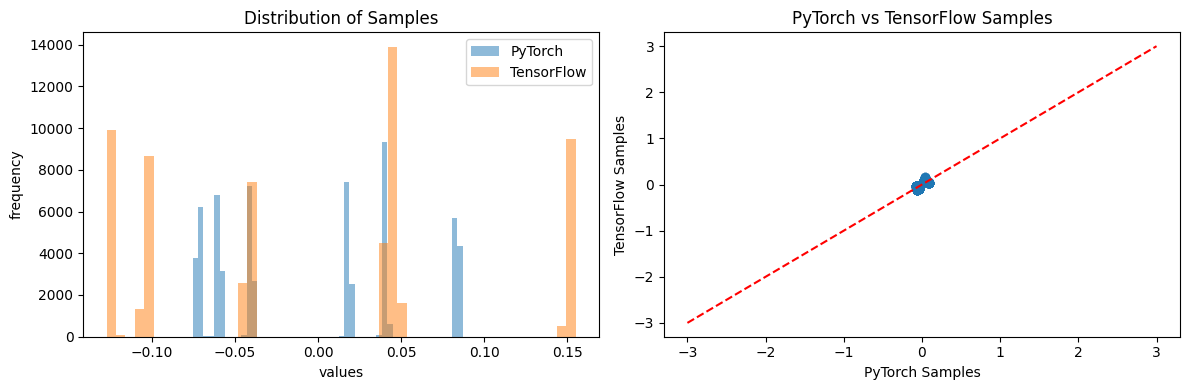

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(torch_samples.flatten(), bins=50, alpha=0.5, label='PyTorch')
plt.hist(tf_samples.flatten(), bins=50, alpha=0.5, label='TensorFlow')
plt.legend()
plt.xlabel("values")
plt.ylabel("frequency")
plt.title("Distribution of Samples")

plt.subplot(122)
plt.scatter(torch_samples.flatten()[:1000], tf_samples.flatten()[:1000], alpha=0.1)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("PyTorch Samples")
plt.ylabel("TensorFlow Samples")
plt.title("PyTorch vs TensorFlow Samples")

plt.tight_layout()
plt.show()

# Test - Bayesian Module (nn.base)

## Redefining the classes for each backend

In [20]:
class TorchBayesianModule(torch.nn.Module):
    """
    A base class for creating a Bayesion Module.
    Each of the functions is subsequently override by the specific backend.
    """

    frozen: bool

    def __init__(self):

        # Call super class constructor
        super().__init__()

        # Set freeze false by default
        self.frozen = False

    def freeze(self) -> None:

        # Set frozen indicator to true for current layer
        self.frozen = True

        # Set frozen indicator to true for children
        for module in self.modules():
            if self != module and isinstance(module, TorchBayesianModule):
                module.freeze()
            else:
                continue

    def unfreeze(self) -> None:

        # Set frozen indicator to false for current layer
        self.frozen = False

        # Set frozen indicators to false for children
        for module in self.modules():
            if self != module and isinstance(module, TorchBayesianModule):
                module.unfreeze()
            else:
                continue
                
    @abstractmethod
    def kl_cost(self) -> Tuple[Any, int]:
        pass

In [21]:
class TFBayesianModule(tf.keras.Model):
    """
    A base class for creating a Bayesion Module.
    Each of the functions is subsequently override by the specific backend.
    """

    frozen: bool

    def __init__(self):

        # Call super class constructor
        super().__init__()

        # Set freeze false by default
        self.frozen = False

    def freeze(self) -> None:

        # Set frozen indicator to true for current layer
        self.frozen = True

        # Set frozen indicator to true for children
        for layer in self.submodules:
            if isinstance(layer, TFBayesianModule):
                layer.freeze()
            else:
                continue
       
    def unfreeze(self) -> None:

        # Set frozen indicator to false for current layer
        self.frozen = False

        # Set frozen indicators to false for children
        for layer in self.submodules:
            if isinstance(layer, TFBayesianModule):
                layer.unfreeze()
            else:
                continue

    @abstractmethod
    def kl_cost(self) -> Tuple[Any, int]:
        pass

## Class definitions - forward method to test

In [22]:
class TorchTestModule(TorchBayesianModule):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 5)

    def forward(self, x):
        return self.linear(x)

    def kl_cost(self):
        return torch.tensor(1.0), 1

In [23]:
class TFTestModule(TFBayesianModule):
    def __init__(self):
        super().__init__()
        self.linear = tf.keras.layers.Dense(5)

    def call(self, x):
        return self.linear(x)

    def kl_cost(self):
        return tf.constant(1.0), 1

## Initialize modules

In [24]:
torch_module=TorchTestModule()

In [25]:
tf_module=TFTestModule()

## Test 1 - Bayesion Module freeze and unfreeze

In [26]:
def test_freeze_unfreeze():
    
    print("Testing freeze and unfreeze...")
    
    # Test PyTorch module
    assert not torch_module.frozen, "PyTorch module should not be frozen initially"
    torch_module.freeze()

    assert torch_module.frozen, "PyTorch module should be frozen after freeze()"
    torch_module.unfreeze()

    assert not torch_module.frozen, "PyTorch module should not be frozen after unfreeze()"

    # Test TensorFlow module
    assert not tf_module.frozen, "TensorFlow module should not be frozen initially"
    tf_module.freeze()

    assert tf_module.frozen, "TensorFlow module should be frozen after freeze()"
    tf_module.unfreeze()

    assert not tf_module.frozen, "TensorFlow module should not be frozen after unfreeze()"
    
    print("Freeze and unfreeze test passed!",'\n\n')

## Test 2 - Bayesion Module KL cost

In [27]:
def test_kl_cost():

    print("Testing KL cost...")
    
    torch_kl, torch_n = torch_module.kl_cost()
    tf_kl, tf_n = tf_module.kl_cost()

    print(f'\nPyTorch : {torch_kl.item()}, {torch_n}')
    print(f'TensorFlow : {tf_kl.numpy()}, {tf_n}\n')

    assert torch_kl.item() == tf_kl.numpy(), f"KL divergence mismatch: PyTorch {torch_kl.item()}, TensorFlow {tf_kl.numpy()}"
    assert torch_n == tf_n, f"N mismatch: PyTorch {torch_n}, TensorFlow {tf_n}"
    
    print("KL cost test passed!",'\n\n')

## Test 3 - Bayesion Module forward pass

In [28]:
def test_forward_pass():

    print("Testing forward pass...")
    
    # Input data
    input_data = np.random.randn(1, 10).astype(np.float32)
    
    # PyTorch forward pass
    torch_input = torch.from_numpy(input_data)
    torch_output = torch_module(torch_input)

    # TensorFlow forward pass
    tf_input = tf.convert_to_tensor(input_data)
    tf_output = tf_module(tf_input)

    # Compare outputs
    torch_np = torch_output.detach().numpy()
    tf_np = tf_output.numpy()
    
    max_diff = np.max(np.abs(torch_np - tf_np))
    print(f"Maximum absolute difference: {max_diff}")
    
    if max_diff > 1e-1:
        print("""
              Warning-Ignore for now: Outputs differ slighlty,this might be due to different 
              initialization or computational differences between PyTorch and TensorFlow for 
              torch.nn.Linear && tf.keras.layers.Dense 
              """
        )
        print("PyTorch output:", torch_np)
        print("TensorFlow output:", tf_np)
    else:
        print("Outputs are close enough.")

    # Use a more lenient comparison
    np.testing.assert_allclose(torch_np, tf_np, rtol=1, atol=1)
    
    print("Forward pass test passed!",'\n\n')

## Run all tests

In [29]:
def run_all_tests():
    
    test_freeze_unfreeze()
    test_kl_cost()
    test_forward_pass()

run_all_tests()

Testing freeze and unfreeze...
Freeze and unfreeze test passed! 


Testing KL cost...

PyTorch : 1.0, 1
TensorFlow : 1.0, 1

KL cost test passed! 


Testing forward pass...
Maximum absolute difference: 0.797053873538971

              Warning-Ignore for now: Outputs differ slighlty,this might be due to different 
              initialization or computational differences between PyTorch and TensorFlow for 
              torch.nn.Linear && tf.keras.layers.Dense 
              
PyTorch output: [[-0.18379822 -0.46143255 -0.15341528 -0.17569864  0.13840935]]
TensorFlow output: [[-0.05273776  0.14111815  0.34889936  0.62135524 -0.04008356]]
Forward pass test passed! 




# Test - Bayesian Module (nn.losses)

## Import specific classes for each backend

In [30]:
from illia.nn.torch.losses import KLDivergenceLoss as TorchKLDivergenceLoss, ELBOLoss as TorchELBOLoss 
from illia.nn.torch.losses import KLDivergenceLoss as TFKLDivergenceLoss, ELBOLoss as TFELBOLoss

from illia.nn.torch.linear import Linear as TorchLinear
from illia.nn.tf.linear import Linear as TFLinear

## Using the classes for each backend defined previously

In [31]:
class TorchTestModule(TorchBayesianModule):

    def __init__(self):

        super().__init__()

        self.linear = TorchLinear(10, 5)

    def forward(self, x):

        return self.linear(x)

    def kl_cost(self):

        return torch.tensor(1.0), 1

In [32]:
class TFTestModule(TFBayesianModule):

    def __init__(self):

        super().__init__()

        self.linear = TFLinear(10, 5)

    def forward(self, x):

        return self.linear(x)

    def kl_cost(self):

        return tf.constant(1.0), 1

## Defining the classes

In [33]:
torch_kl_divengence = TorchKLDivergenceLoss()
torch_elbo_loss = TorchELBOLoss(loss_function=torch.nn.MSELoss())
torch_module = TorchTestModule()

In [34]:
tf_kl_divengence = TFKLDivergenceLoss()
tf_elbo_loss = TFELBOLoss(loss_function=tf.keras.losses.MeanSquaredError())
tf_module = TFTestModule()

In [35]:
list(torch_module.parameters())

[Parameter containing:
 tensor([[ 0.0479, -0.0953,  0.0832, -0.0802, -0.0124,  0.0589,  0.1986, -0.0395,
          -0.0253, -0.0271],
         [ 0.0519,  0.1051,  0.0133,  0.0012, -0.0167, -0.0245, -0.0145, -0.2306,
           0.0007, -0.1667],
         [-0.0346,  0.0186,  0.1589, -0.0155, -0.1691, -0.0600,  0.0923,  0.0387,
           0.0047, -0.0468],
         [-0.0177, -0.0492, -0.0623,  0.0299,  0.0616,  0.0480,  0.0757,  0.0764,
           0.0238,  0.1908],
         [ 0.0833,  0.0861,  0.1527, -0.0295,  0.0064, -0.2627,  0.2182, -0.0113,
          -0.0095, -0.0281]], requires_grad=True),
 Parameter containing:
 tensor([[-6.9870, -6.9369, -6.9303, -6.8607, -6.9403, -7.0447, -6.9310, -6.9628,
          -7.0964, -7.0285],
         [-7.0113, -7.0355, -7.1340, -6.9797, -6.8941, -6.9065, -6.9770, -6.8039,
          -7.0734, -7.0027],
         [-6.9284, -7.0237, -6.8781, -6.8916, -6.9251, -7.0902, -6.9027, -7.0013,
          -6.9030, -7.2042],
         [-7.0385, -6.9335, -7.0717, -6.9382

## Test 1 - Check if parameters are available

In [36]:
def check_parameters():

    print("Check the existence of trainable parameters in the classes...")

    torch_list_parameters = list(torch_module.parameters())
    assert len(torch_list_parameters) != 0, "No parameters availables in TorchTestModule"
    
    print("Test passed!",'\n\n')

## Test 2 - Check losses

In [37]:
def check_forward_losses():

    print("Check the forward propagation of the loss functions...")
        
    # Input data
    input_data = np.random.randn(1, 10).astype(np.float32)
    y_true = np.random.randn(1, 10).astype(np.float32)
    y_pred = np.random.randn(1, 10).astype(np.float32)

    # PyTorch forward pass
    torch_input = torch.from_numpy(input_data)
    torch_output = torch_module(torch_input)
    torch_kl_divengence_output = torch_kl_divengence(torch_module)
    torch_elbo_loss_output = torch_elbo_loss(torch.from_numpy(y_true), torch.from_numpy(y_pred), torch_module)

    print("Test passed!",'\n\n')

## Run all tests

In [38]:
def run_all_tests():
    
    check_parameters()
    check_forward_losses()

run_all_tests()

Check the existence of trainable parameters in the classes...
Test passed! 


Check the forward propagation of the loss functions...
Test passed! 


